In [36]:
from typing import Annotated, Literal, TypeVar

import numpy as np
import numpy.typing as npt

import matplotlib.pyplot as plt
import math
from PIL import Image

from sklearn.preprocessing import normalize



DType = TypeVar("DType", bound=np.generic)

LineVector = Annotated[npt.NDArray[DType], Literal[3]]

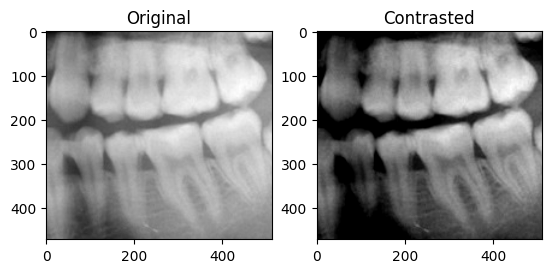

In [2]:
img = Image.open("teeth_sample.png")
img_data = np.array(img)

minval = np.percentile(img_data, 11)
maxval = np.percentile(img_data, 100)

img_contrast = np.clip(img_data.copy(), minval, maxval)
img_contrast = ((img_contrast - minval) / (maxval - minval)) * 255

_, axes = plt.subplots(1, 2)
axes[0].set_title("Original")
axes[0].imshow(img_data, cmap="gray")
axes[1].set_title("Contrasted")
axes[1].imshow(img_contrast, cmap="gray")

In [3]:
class Line:
    def __init__(self, v, *, origin=0, size=1) -> None:
        self.vector = v
        self.size = size
        self.x_values = [i for i in range(0, size, 8)]
        self.y_values = [self.getY(i) for i in self.x_values]
    
    def getXValues(self, size):
        return np.asarray([i for i in range(0, size, 10)])
    
    def getY(self, x):
        x_vector = np.array([x**2, x, 1])
        return np.dot(self.vector, x_vector)
    
    def derivAtX(self, x):
        deriv = np.array([2 * x, 1, 0])
        return np.multiply(self.vector, deriv)
    
    def normVector(self, x):
        dirv = self.derivAtX(x)
        transformMatrix = np.array([[0, -1], [1, 0], [0, 0]])
        return np.matmul(dirv, transformMatrix)

In [13]:
class SlidingWindow():
    def __init__(self, 
                 img: npt.NDArray, 
                 num_steps: int,  
                 *,
                 median: int = None,
                 medians: list[int] = [],
                 sigma: int = None,
                 sigmii: list[int] = [],
                 constant: int = 10,
                 line: LineVector[np.float64] = np.array([0, 0, 0]),
                 strip: int = 0,
                 horiz: bool= False, 
                 vert: bool= True, 
                 top: bool= False, 
                 bot: bool= False,
                 diagnose: bool= False,
                 diag_num: int= 1
                 ) -> None:
        # parameters
        self.img = img if horiz or not vert else img.copy()[:, :-strip]
        self.img_width = self.img.shape[1]
        self.img_height = self.img.shape[0]
        self.window_length = self.img_height if vert and not horiz else self.img_width
        self.num_steps = num_steps
        
        self.window_width = round(self.img_height / (self.num_steps / 2)) if horiz or not vert else round(self.img_width / (self.num_steps / 2))
        
        if len(medians) != len(sigmii):
            raise Exception(f"Medians and sigmii need to be same size. <medians: len({len(medians)}> - <sigmii: len({len(sigmii)}))")
        
        self.medians = [median] if median is not None and len(medians) == 0 else medians
        self.sigmii = [sigma] if sigma is not None and len(sigmii) == 0 else sigmii
        # print(f"median: {self.medians}")
        # print(f"sigmii: {self.sigmii}")
        self.normals = np.asarray([
            self.normalDistVector(size=self.window_length, median=self.medians[i], sigma=self.sigmii[i]) 
            for i in range(len(self.medians))]).transpose()
        
        self.segm_line = Line(line)
        self.constant = constant
        
        # booleans
        self.isHoriz = horiz
        self.isVert = vert
        self.isTop = top
        self.isBot = bot
        self.isDiagnosing = diagnose
        self.diag_num = diag_num
        
        self.x_positions, self.y_positions = self.slide()
        self.vector = line
        
        
    def slide(self):
        if self.isDiagnosing:
            self.num_steps= self.diag_num
        
        position_x = []
        position_y = []
        step_length = round(self.window_width / 2)
        for step in range(self.num_steps):
            current_loc = step * step_length
            window = self.getSlide(current_loc)
            
            if self.isHoriz or not self.isVert:
                window = window.transpose()
                
                # break the window if it's current location is crossing the line
                # found in the upper and lower segmentation sliding window
                if self.isTop and current_loc  > self.segm_line.getY(self.img_width / 2) - self.window_width:
                    continue
                elif self.isBot and current_loc < self.segm_line.getY(self.img_width / 2) + self.window_width or current_loc + self.window_width > self.img_height:
                    continue
                    
                
            window_vector = self.computeWindow(window)
            if self.isDiagnosing:
                print(f"After Computing: step {step}")
                print(f"window vector: {window_vector.shape}")
                print(f"Window: {window.shape}")
                print(f"Normals: {self.normals.shape}\n")
                
            max_medians = []
            for i in range(self.normals.shape[1]):
                argument_max = np.argmax(window_vector[:, i])
                window_vector[argument_max, i] = 0
                max_medians.append(argument_max)
                
                # if self.isDiagnosing:
                #     print(i)
                #     print(f"argument max: {argument_max}")
        
            if self.isHoriz or not self.isVert:
                position_x.append(np.asarray(max_medians))
                position_y.append(np.asarray([round(current_loc + (self.window_width / 2)) for i in range(self.normals.shape[1])] ))
            else:
                position_y.append(np.asarray(max_medians))
                position_x.append(round(current_loc + (self.window_width / 2)))

        
        if self.isHoriz or not self.isVert:
            if self.isDiagnosing:
                print(f"Returning: ")
                print(f"x's: {np.asarray(position_x).shape}")
                # print(f"next index: {position_y[0]}")
                print(f"y's: {np.asarray(position_y).shape}")
            
            return np.asarray(position_x), np.asarray(position_y)
        
        return np.asarray(position_x)[np.newaxis].transpose(), np.asarray(position_y)

    
    def getSlide(self, window_location):
        '''
        Slices the image by the defined window sizes at the current location
        '''
        if self.isVert and not self.isHoriz:
            return self.img[:self.window_length, window_location: window_location + self.window_width].copy()
            
        return self.img[window_location: window_location + self.window_width, :self.window_length].copy()


    def computeWindow(self, window):
        
            # v_probabilites = np.ones((v_probabilites.shape[0], 1))
          
        # get the average of each row by vector multiplication
        # with a vector of ones
        kernel = np.ones((window.shape[1], 1), dtype=np.int32)
        avg_intensity_vector = np.matmul(window, kernel) / self.window_width
        
        # find the maximum intensity in the averages and assign a probability
        # for each of the intensities in the average intensity vector
        #
        # there is a constant that I am not sure what it does, but was in
        # the slides
        D_max = np.max(avg_intensity_vector)
        prob_Di = self.constant * (1 - (avg_intensity_vector / D_max) )
        
        
        if self.isDiagnosing:
            print(f"window: {window.shape}")
            print(f"kernel: {kernel.shape}")
            print(f"intensity: {avg_intensity_vector.shape}")
            print(f"prob_di: {prob_Di.shape}")
            print(f"normals: {self.normals.shape}")
        
        
        # multiply the normally distributed probability vector with
        # the intensity average probability vector elementwise
        if self.isHoriz or not self.isVert:
            return np.multiply(self.normals, prob_Di)
        
        
        return  np.multiply(prob_Di, self.normals)

    
    def gaussianProbability(self, y,*, y_hat=210, sigma=1):
        '''
        Uses the gaussian formula to determine the probabability
        of a given "y" value where the median is y_hat and the sigma
        is another value
        '''
        constant = (math.sqrt(2 * math.pi) * sigma)
        exponent = (-1 * (((y - y_hat) ** 2) / (sigma ** 2)))
        probability = (1 / constant) * math.pow(math.e, (exponent / 2))
        
        return probability


    def normalDistVector(self, *, size=472, median=210, sigma=1, horiz=False, vert=True):
        '''
        With the gaussianProbability function this builds a vector
        of given size that has the percentage of likelihood at the
        given possition based on the median and sigma.
        '''
        probs = []
        for i in range(size):
            prob = self.gaussianProbability(i, y_hat= median, sigma=sigma)
            probs.append(prob)
        
        if horiz or not vert:
            return np.asarray(probs)
        
        return np.array(probs)

    def sampling(self, sample_num):
        step_length = round(self.window_width / 2)

        # Show single sample size for testing purposes
        test_window_loc = sample_num * step_length
        test_window = self.getSlide(test_window_loc)
        # print(f"top_normals: {top_normals.shape}")
        # vector_normal_probabilites = normalDistVector(size=test_window.shape[1], median=median, sigma=sigma)
        # print(f"Normals: {vector_normal_probabilites.shape}")

        # window_vector = computeWindow(test_window, vector_normal_probabilites)
        vector = [0, 1]
        window_x_values = [test_window_loc, test_window_loc + self.window_width]
        if self.isHoriz or not self.isVert:
            test_window = test_window.transpose()
            
        # print(window.shape)
        kernel = np.ones((self.window_width, 1), dtype=np.int32)
        # print(kernel.shape)
        
        avg_intensity_vector = np.matmul(test_window, kernel) / self.window_width
        avg_intens_norm = normalize(avg_intensity_vector, axis=0).ravel()
        
        # normals = normalDistVector(size=window.shape[0], median=median, sigma=sigma)

        ## plot the current slide window
        # add the lines for the slide window
        fig, axes = plt.subplots(1, 3)
        fig.suptitle("Window Slide Single Sample")
        axes[0].set_title("Window Location")
        axes[0].imshow(self.img, cmap="gray")
        if self.isHoriz or not self.isVert:
            axes[0].axhline(test_window_loc, xmin=0, xmax=1)
            axes[0].axhline(test_window_loc + self.window_width, xmin=0, xmax=1)
        else:
            axes[0].axvline(test_window_loc, ymin=0, ymax=1)
            axes[0].axvline(test_window_loc + self.window_width, ymin=0, ymax=1)
        axes[0].plot()
        
        
        axes[1].set_title("Sample")
        axes[1].imshow(test_window, cmap="gray")

        # intensities
        axes[2].set_title("Avg. Intens.")
        axes[2].invert_yaxis()
        axes[2].scatter(avg_intens_norm, range(0, len(avg_intens_norm)))
        
        # normal distribution plot
        # for i in range(normals.shape[0]):
        #     print(i)
        axes[2].plot(self.normals, range(0, len(avg_intensity_vector)), color="red")
        
        plt.show()
    
            

x: (32, 1)
y: (32, 1)


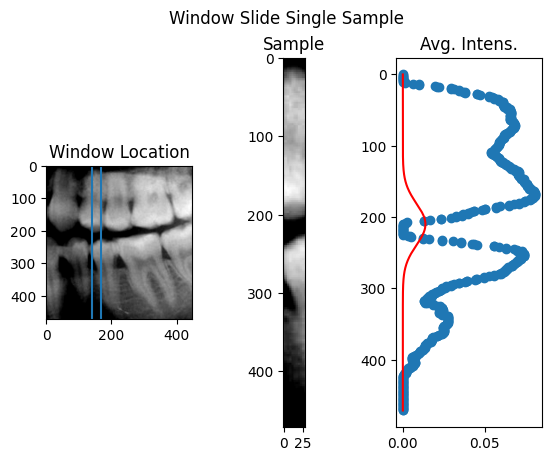

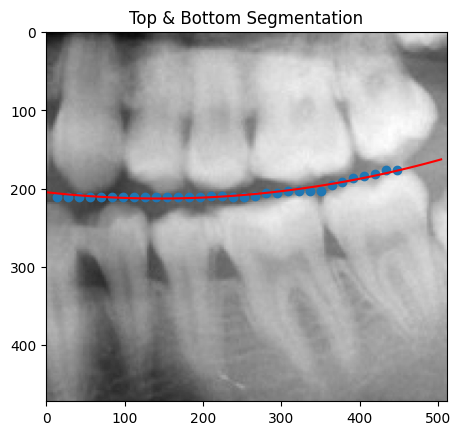

In [69]:
firstWindow = SlidingWindow(img_contrast, 32, median=210, sigma=29, constant=50, strip=64)

print(f"x: {firstWindow.x_positions.shape}")
# print(firstWindow.x_positions)
print(f"y: {firstWindow.y_positions.shape}")
# print(firstWindow.y_positions)
firstWindow.sampling(10)
line_vector = np.polyfit(firstWindow.x_positions[:, 0], firstWindow.y_positions[:, 0], 2)

up_low_seg_line = Line(line_vector, size=img_contrast.shape[1])

plt.title("Top & Bottom Segmentation")
plt.imshow(img_data, cmap="gray")
plt.scatter(firstWindow.x_positions[:, 0], firstWindow.y_positions[:, 0])
plt.plot(up_low_seg_line.x_values, up_low_seg_line.y_values, color="red")
# plt.plot(firstWindow.x_positions, np.polyval(line_vector, firstWindow.x_positions), color="red")
plt.show()


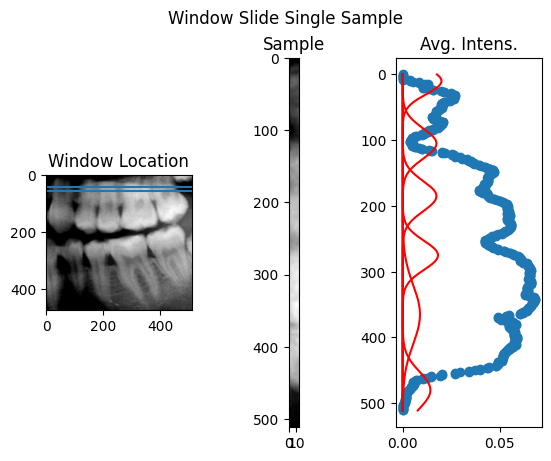

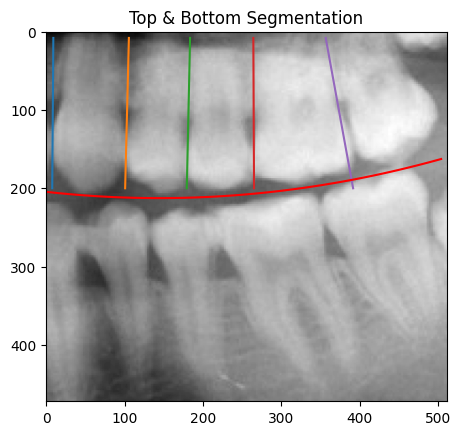

In [182]:
num_slides = 64
top_medians = [10, 105, 185, 275, 365, 480]
top_sigma = [20, 23, 23, 22, 45, 28]
constant = 10

top_window = SlidingWindow(img_contrast, 
                           num_steps=num_slides, 
                           medians=top_medians, 
                           sigmii=top_sigma, 
                           constant=constant, 
                           line=line_vector,
                           horiz=True, 
                           top=True, 
                           diagnose=False, 
                           diag_num=5)

top_window.sampling(5)

plt.title("Top & Bottom Segmentation")
plt.imshow(img_data, cmap="gray")

for i in range(len(top_medians) - 1):
    A = np.vstack([top_window.y_positions[:,i], np.ones(len(top_window.x_positions))] ).T
    n, c = np.linalg.lstsq(A, top_window.x_positions[:,i], rcond=None)[0]

    plt.ylim(top_window.img_height, 0)
    plt.plot(n * top_window.y_positions[:,i] + c, top_window.y_positions[:,i])#, slope=tooth_line[0])
    
    # plt.scatter(top_window.x_positions[:, i], top_window.y_positions[:, i])
    

plt.plot(up_low_seg_line.x_values, up_low_seg_line.y_values, color="red")    
plt.show()

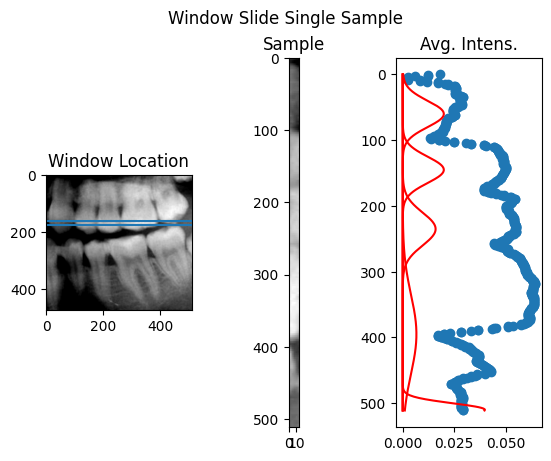

(30, 5)
(30, 5)


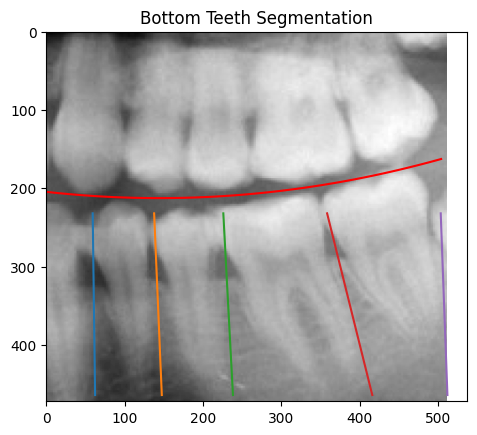

In [166]:

bot_num_slides = 64
bot_medians = [60, 145, 235, 395, 510]
bot_sigma = [20, 20, 25, 60, 10]

constant = 20
bottom_window = SlidingWindow(img_contrast, 
                           num_steps=bot_num_slides, 
                           medians=bot_medians, 
                           sigmii=bot_sigma, 
                           constant=constant, 
                           line=line_vector,
                           horiz=True, 
                           bot=True, 
                           diagnose=False, 
                           diag_num=5)

bottom_window.sampling(20)
print(bottom_window.x_positions.shape)
print(bottom_window.y_positions.shape)

plt.title("Bottom Teeth Segmentation")
plt.imshow(img_data, cmap="gray")
for i in range(len(bot_medians)):
    A = np.vstack([bottom_window.y_positions[:,i], np.ones(len(bottom_window.x_positions))] ).T
    n, c = np.linalg.lstsq(A, bottom_window.x_positions[:,i], rcond=None)[0]

    plt.ylim(bottom_window.img_height, 0)
    plt.plot(n * bottom_window.y_positions[:,i] + c, bottom_window.y_positions[:,i])#, slope=tooth_line[0])
    
    # plt.scatter(top_window.x_positions[:, i], top_window.y_positions[:, i])

plt.plot(up_low_seg_line.x_values, up_low_seg_line.y_values, color="red")    
plt.show()

# Testing Code

In [ ]:
norm = np.linalg.norm(line.vector)
print(line.vector)
print(line.getY(400))
print(norm)
print(line.derivAtX(400))
print(line.normVector(400))
norm_vector = line.normVector(400)
origin = np.array([400, line.getY(400)])

points = np.asarray([ origin + np.multiply(norm_vector, i * 10)  for i in range(50)])

# print(points)
plt.imshow(img_contrast, cmap="gray")
plt.plot(points[:, 0], points[:, 1], color="red")
plt.show()

In [ ]:
num_slides = 32
window_width = round(img_data.shape[1] / (num_slides / 2)) # dividing by two so the step pattern will overlap
step_number = 10 # current step number // starting at 10 for example will loop through this variable along num_slides
window_height = img_data.shape[0]

# define the window size and location in regards to
# the image
step_length = round(window_width / 2)
current_window_loc = step_number * step_length

window = getSlideWindow(img_contrast, current_window_loc, window_width)

v_probabilites = normalDistVector(size=window.shape[0], median=210, sigma=5)
window_vector = computeWindow(window, v_probabilites)

showWindowInfo(img_contrast, current_window_loc, width=window_width)


In [ ]:
def showSlideWindow(current_window_loc, width, height, img, *, horiz=False, vert=True):
    line_width = 3
    window_plot = img.copy()
    
    if horiz or not vert:
        window_plot[current_window_loc: current_window_loc + line_width, :height] = 0
        window_plot[current_window_loc + width - line_width: current_window_loc + width, :height] = 0
    else:
        window_plot[:height, current_window_loc: current_window_loc + line_width] = 0
        window_plot[:height, current_window_loc + width - line_width: current_window_loc + width] = 0
    
    return window_plot

def getSlideWindow(img, window_location, window_width, *, horiz=False, vert=True):
    if vert and not horiz:
        window_length = img.shape[0]
        return img[:window_length, window_location: window_location + window_width].copy()
    else:
        window_length = img.shape[1]
        return img[window_location: window_location + window_width, :window_length].copy()



def gaussianProbability(y,*, y_hat=210, sigma=1):
    '''
    Uses the gaussian formula to determine the probabability
    of a given "y" value where the median is y_hat and the sigma
    is another value
    '''
    constant = (math.sqrt(2 * math.pi) * sigma)
    exponent = (-1 * (((y - y_hat) ** 2) / (sigma ** 2)))
    probability = (1 / constant) * math.pow(math.e, (exponent / 2))
    
    return probability

def normalDistVector(*, size=472, median=210, sigma=1, horiz=False, vert=True):
    '''
    With the gaussianProbability function this builds a vector
    of given size that has the percentage of likelihood at the
    given possition based on the median and sigma.
    '''
    probs = []
    for i in range(size):
        prob = gaussianProbability(i, y_hat= median, sigma=sigma)
        probs.append(prob)
    
    if horiz or not vert:
        return np.asarray(probs)
    
    return np.array(probs)[np.newaxis]


''' Deprecated '''
# def intensityProbability(d_i, d_vector, constant):
#     '''
#     Will be multiplied with a constant later.
#     '''
#     max = np.max(d_vector)
    
#     if max == 0:
#         return 0.0
    
#     return constant * (1 - (d_i / max))

def computeWindow(window, v_probabilites, constant, *, horiz=False, vert=True):
    if horiz or not vert:
        window = window.transpose()
        # v_probabilites = np.ones((v_probabilites.shape[0], 1))
        
    width = window.shape[1]
    # height = window.shape[0]
    # print(window.shape)
    
    # get the average of each row by vector multiplication
    # with a vector of ones
    kernel = np.ones((width, 1), dtype=np.int32)
    avg_intensity_vector = np.matmul(window, kernel) / width
    # print(f"intensity: {avg_intensity_vector.shape}")
    
    # find the maximum intensity in the averages and assign a probability
    # for each of the intensities in the average intensity vector
    #
    # there is a constant that I am not sure what it does, but was in
    # the slides
    D_max = np.max(avg_intensity_vector)
    prob_Di = constant * (1 - (avg_intensity_vector / D_max) )
    # print(f"prob_di: {prob_Di.shape}")
    # print(f"Normals: {v_probabilites.shape}")
    
    # multiply the normally distributed probability vector with
    # the intensity average probability vector elementwise
    # if horiz or not vert:
    #     return np.multiply(v_probabilites, prob_Di)
    
    return  np.multiply(v_probabilites.transpose(), prob_Di)
    

def showWindowInfo(img, current_window_loc, normals, *,width=32, height=1, median=195, sigma=142, horiz=False, vert=True):
    window = getSlideWindow(img, current_window_loc, width, horiz=horiz)
    height = img.shape[0]
    if horiz or not vert:
        window = window.transpose()
        height = img.shape[1]
        
    # print(window.shape)
    kernel = np.ones((width, 1), dtype=np.int32)
    # print(kernel.shape)
    
    avg_intensity_vector = np.matmul(window, kernel) / width
    avg_intens_norm = normalize(avg_intensity_vector, axis=0).ravel()
    
    # normals = normalDistVector(size=window.shape[0], median=median, sigma=sigma)

    ## plot the current slide window
    # add the lines for the slide window
    window_sample = showSlideWindow(current_window_loc, width, height, img, horiz=horiz)
    
    fig, axes = plt.subplots(1, 3)
    fig.suptitle("Window Slide Single Sample")
    axes[0].set_title("Window Location")
    axes[0].imshow(window_sample, cmap="gray")
    
    axes[1].set_title("Sample")
    axes[1].imshow(window, cmap="gray")

    # intensities
    axes[2].set_title("Avg. Intens.")
    axes[2].invert_yaxis()
    axes[2].scatter(avg_intens_norm, range(0, len(avg_intens_norm)))
    
    # normal distribution plot
    # for i in range(normals.shape[0]):
    #     print(i)
    axes[2].plot(normals.transpose(), range(0, len(avg_intensity_vector)), color="red")
    
    plt.show()


 

## Upper and Lower Segmentation

In [ ]:
num_slides = 64
median = 200
sigma = 42
constant = 10

sliced_img = img_contrast[:, : -64] # get rid of the right side of the image which messes with the data a bit

window_width = round(sliced_img.shape[1] / (num_slides / 2)) # dividing by two so the step pattern will overlap
step_length = round(window_width / 2)

# Show single sample size for testing purposes
test_window_loc = 5 * step_length
test_window = getSlideWindow(img_contrast, test_window_loc, window_width)
vector_normal_probabilites = normalDistVector(size=test_window.shape[0], median=median, sigma=sigma)

# window_vector = computeWindow(test_window, vector_normal_probabilites)
showWindowInfo(img_contrast, test_window_loc, vector_normal_probabilites, width=window_width, sigma=sigma)

position_y = []
position_x = []
for step_number in range(num_slides):
    window_height = sliced_img.shape[0]

    # define the window size and location in regards to
    # the image
    current_window_loc = step_number * step_length
    window = getSlideWindow(sliced_img.copy(), current_window_loc, window_width)

    window_vector = computeWindow(window, vector_normal_probabilites, constant)
    # print(f"Slide {step_number}: {window_vector.shape}\n")
    
    argument_max = np.argmax(window_vector)
    # print(argument_max)
    
  
    position_y.append(argument_max)
    position_x.append(round(current_window_loc + (window_width / 2)))
    

line_vector = np.polyfit(position_x, position_y, 2)

up_low_seg_line = Line(line_vector, size=img_contrast.shape[1])

plt.title("Top & Bottom Segmentation")
plt.imshow(img_contrast, cmap="gray")
plt.scatter(position_x, position_y)
plt.plot(up_low_seg_line.x_values, up_low_seg_line.y_values, color="red")
# plt.plot(position_x, np.polyval(line_vector, position_x), color="red")
plt.show()


## Tooth to tooth Segmentation

In [ ]:
num_slides = 32
top_medians = [15, 110, 185, 275, 380, 480]
bot_medians = [70, 155, 245, 390, 510]
sigma = 42
constant = 10

window_width = round(img_contrast.shape[0] / (num_slides / 2)) # dividing by two so the step pattern will overlap
step_length = round(window_width / 2)

# Show single sample size for testing purposes
test_window_loc = 2 * step_length
test_window = getSlideWindow(img_contrast, test_window_loc, window_width, horiz=True)
vector_normal_probabilites = np.ones((test_window.shape[1], 1))
top_normals = np.asarray([normalDistVector(size=test_window.shape[1], median=m, sigma=sigma, horiz=True) for m in top_medians])
# print(f"top_normals: {top_normals.shape}")
# vector_normal_probabilites = normalDistVector(size=test_window.shape[1], median=median, sigma=sigma)
# print(f"Normals: {vector_normal_probabilites.shape}")

# window_vector = computeWindow(test_window, vector_normal_probabilites)
showWindowInfo(img_contrast, test_window_loc, top_normals, width=window_width, sigma=sigma, horiz=True)

position_y = []
position_x = []
for step_number in range(num_slides):
    window_height = sliced_img.shape[0]

    # define the window size and location in regards to
    # the image
    current_window_loc = step_number * step_length
    if current_window_loc > 170:
        break
    
    # print(current_window_loc)
    window = getSlideWindow(img_contrast.copy(), current_window_loc, window_width, horiz=True)

    window_vector = computeWindow(window, top_normals, constant, horiz=True)
    # print(f"Slide {step_number}: {window_vector.shape}\n")
    
    max_medians = []
    for i in range(len(top_medians)):
        # print(i)
        argument_max = np.argmax(window_vector[:, i])
        window_vector[argument_max, i] = 0
        max_medians.append(argument_max)
        
    # print(argument_max)
    
    position_x.append(np.asarray(max_medians))
    position_y.append(round(current_window_loc + (window_width / 2)))
    
p_x = np.asarray(position_x)
p_y = np.asarray(position_y)

print(f"p_x: {p_x.shape}")
print(f"p_y: {p_y.shape}")
# line_vector = np.polyfit(position_x, position_y, 2)

# upper_lower_segmentation = Line(line_vector)

plt.title("Top & Bottom Segmentation")
plt.imshow(img, cmap="gray")

for i in range(len(top_medians)):
    plt.scatter(p_x[:, i], p_y[:])

plt.plot(up_low_seg_line.x_values, up_low_seg_line.y_values, color="red")
# plt.plot(position_x, np.polyval(line_vector, position_x), color="red")
plt.show()
